In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 200

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Temporal MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [4]:
sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [5]:
sc_param_df[sc_param_df['quality'] == 1]

,dataset,method,metric,quality,N0,s,I_inf,I_0,mean_residual
9,PBMC,Geneformer,Cell type MI,1.0,264.920,0.165,3.508,1.000,0.139
19,PBMC,Geneformer,Protein MI,1.0,4561.610,1.999,3.620,1.697,0.585
29,PBMC,PCA,Cell type MI,1.0,16010.994,0.461,3.384,3.084,0.135
39,PBMC,PCA,Protein MI,1.0,20416.934,0.490,4.400,3.573,0.197
49,PBMC,Rand. Proj.,Cell type MI,1.0,19668.381,0.486,2.514,2.281,0.099
59,PBMC,Rand. Proj.,Protein MI,1.0,15583.450,0.446,2.930,2.705,0.110
69,PBMC,SCVI,Cell type MI,1.0,23883.032,0.142,4.512,2.731,0.079
79,PBMC,SCVI,Protein MI,1.0,4951.539,1.435,4.768,2.515,0.352
89,larry,Geneformer,Clonal MI,1.0,170.391,0.849,1.070,0.032,0.157
99,larry,PCA,Clonal MI,1.0,65172.763,0.964,1.839,1.318,0.137


In [6]:
pretty_palette = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]

def plot_points(ax, x, y, color, label):
    ax.plot(x, y, color=color, marker='o', alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def plot_precomputed(ax, df, param_df, palette, plot_fits=False):
    """plots data that has pre-calculated fit parameters."""
    print('plotting pre-computed data... go!')
    hue_order = ['PCA', 'Geneformer', 'SCVI']

    n_curves = 0

    # loop through all our datasets
    for idx, sig in enumerate(df['signal'].unique()):
        for q in df['quality'].unique():
            for alg in hue_order:
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]

                if len(data) < 10: continue

                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]

                N_hat = (x/N0)**-s

                # remove if N_hat > I_inf
                mask = N_hat < I_inf
                N_hat = N_hat[mask]
                y = y[mask]

                plot_points(ax, N_hat, I_inf-y, palette[idx], sig)
                if len(y) > 0:
                    n_curves += 1
    print(f'Plotted {n_curves} curves.')

                # if plot_fits:
                #     xs = np.logspace(-4, 3.5, 100)
                #     a, b = 1 / xbar, (1 / xbar) * (2**(2 * imax))
                #     ys = info_scaling(xs, a, b)
                #     plot_fit(ax, xs / xbar, ys / imax, palette[idx])

plotting pre-computed data... go!
Plotted 139 curves.


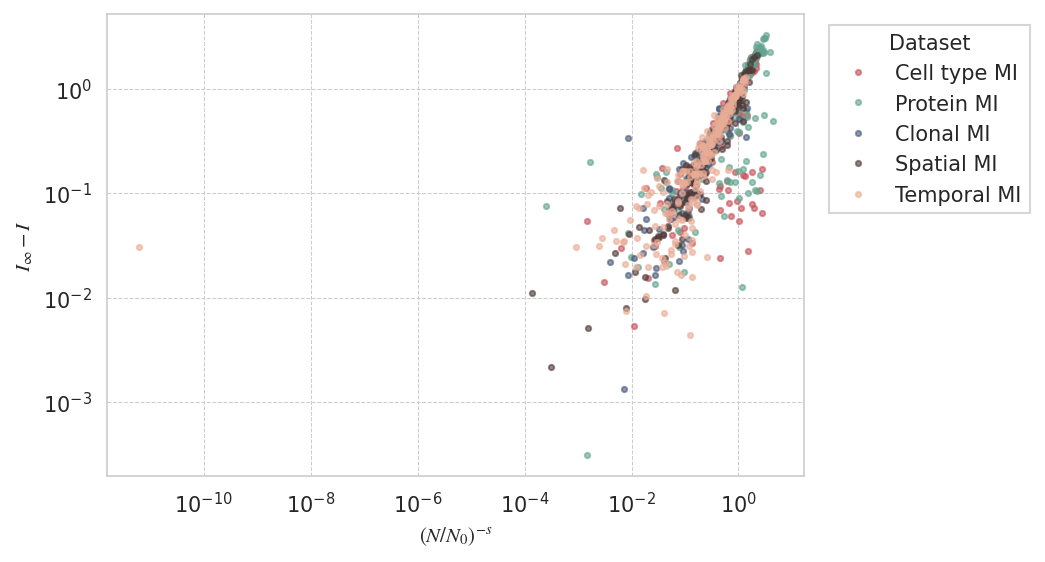

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(N/N_0)^{-s}$')
ax.set_ylabel(r'$I_{\infty} - I$')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')

plotting pre-computed data... go!
Plotted 139 curves.


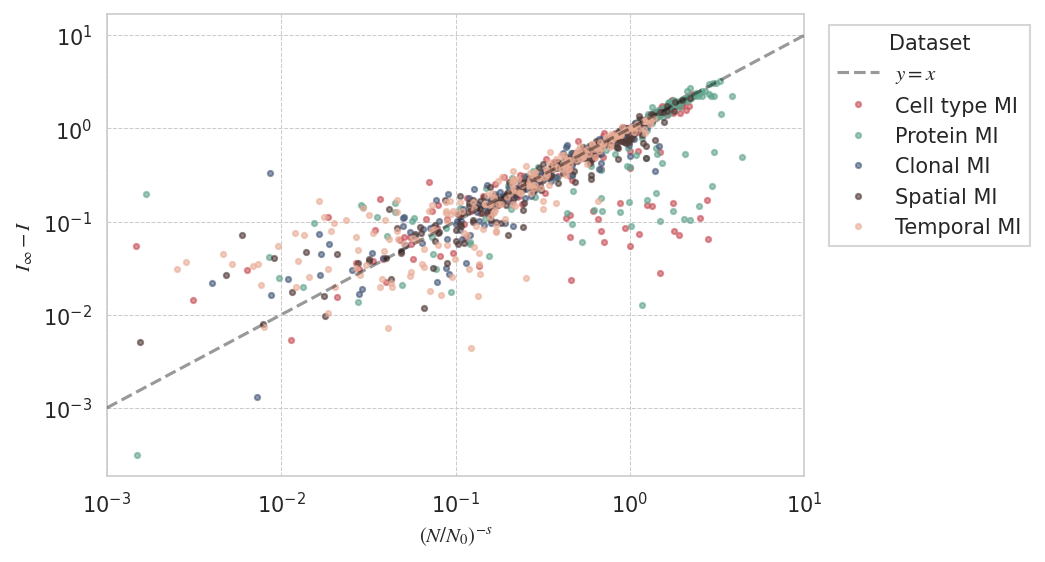

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

xs = np.logspace(-3, 1, 100)
ax.plot(xs, xs, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = x$',zorder=10)



# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(N/N_0)^{-s}$')
ax.set_ylabel(r'$I_{\infty} - I$')
ax.set_xlim(1e-3, 1e1)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')

     dataset      method        metric  quality         N0      s  I_inf  \
0       PBMC  Geneformer    Protein MI      1.0   4561.610  1.999  3.620   
1       PBMC        SCVI    Protein MI      1.0   4951.539  1.435  4.768   
2      larry        SCVI     Clonal MI      1.0    416.300  1.007  1.768   
3      larry         PCA     Clonal MI      1.0  65172.763  0.964  1.839   
4    merfish         PCA    Spatial MI      1.0  43505.377  0.858  2.358   
5      larry  Geneformer     Clonal MI      1.0    170.391  0.849  1.070   
6    merfish  Geneformer    Spatial MI      1.0    135.075  0.523  1.304   
7       PBMC         PCA    Protein MI      1.0  20416.934  0.490  4.400   
8       PBMC         PCA  Cell type MI      1.0  16010.994  0.461  3.384   
9   shendure  Geneformer   Temporal MI      1.0    165.343  0.402  2.003   
10  shendure         PCA   Temporal MI      1.0      0.450  0.275  1.177   
11  shendure        SCVI   Temporal MI      1.0    204.556  0.272  2.429   
12   merfish

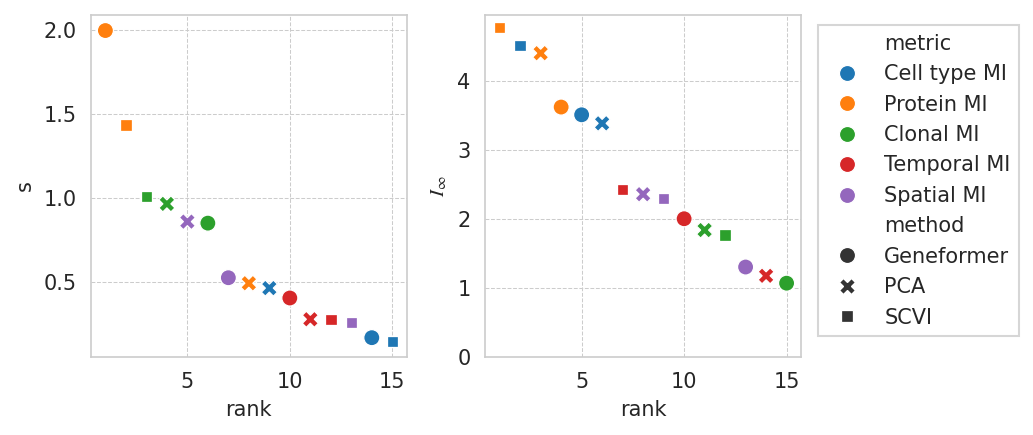

In [15]:
# compute rank of s (highest to lowest)
subset = sc_param_df[sc_param_df['quality'] == 1]
subset = subset[subset['method'] != 'Rand. Proj.']
ranked = subset.sort_values('s', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1
print(ranked)

# plot
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.scatterplot(
    data=ranked,
    x='rank', y='s',
    hue='metric',
    palette='tab10',
    style='method',
    s=60,
    edgecolor='w',
    ax=axs[0],
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
    legend=False
)

ranked = subset.sort_values('I_inf', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1

sns.scatterplot(
    data=ranked,
    x='rank', y='I_inf',
    hue='metric',
    palette='tab10',
    style='method',
    s=60,
    edgecolor='w',
    ax=axs[1],
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
)
plt.xlabel('rank')
axs[1].set_ylabel(r'$I_\infty$')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left',)
plt.ylim(0, )
plt.tight_layout()
plt.show()

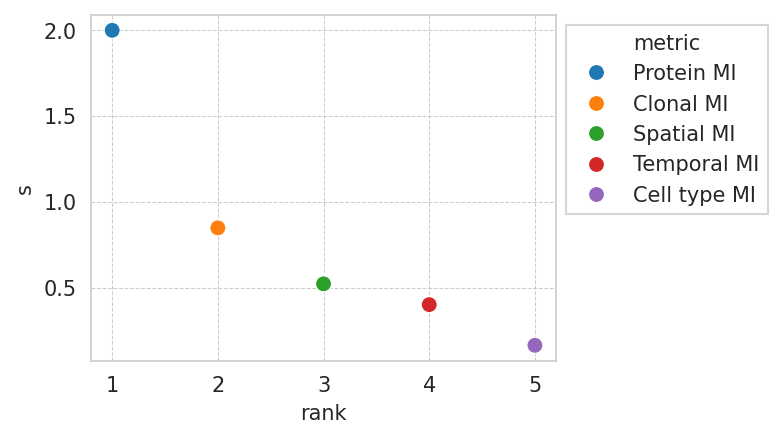

In [16]:
subset = subset[subset['method'] == 'Geneformer']
ranked = subset.sort_values('s', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1

g = sns.scatterplot(
    data=ranked,
    x='rank', y='s',
    hue='metric',
    palette='tab10',
    # style='method',
    s=60,
    edgecolor='w',
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [13]:
subset

,dataset,method,metric,quality,N0,s,I_inf,I_0,mean_residual
9,PBMC,Geneformer,Cell type MI,1.0,264.920,0.165,3.508,1.000,0.139
19,PBMC,Geneformer,Protein MI,1.0,4561.610,1.999,3.620,1.697,0.585
89,larry,Geneformer,Clonal MI,1.0,170.391,0.849,1.070,0.032,0.157
129,merfish,Geneformer,Spatial MI,1.0,135.075,0.523,1.304,0.419,0.088
169,shendure,Geneformer,Temporal MI,1.0,165.343,0.402,2.003,0.583,0.054
